In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import soccertrack
from soccertrack import Camera
from soccertrack.logger import show_df, tqdm # This just makes the df viewable in the notebook.

dataset_path = soccertrack.datasets.get_path('top-view')
path_to_csv = sorted(dataset_path.glob('annotations/*.csv'))[0]
path_to_mp4 = sorted(dataset_path.glob('videos/*.mp4'))[0]

bbdf = soccertrack.load_df(path_to_csv) # We will use this as ground truth
show_df(bbdf.head())

In [3]:
import numpy as np
from motpy import Detection

from joblib import Parallel, delayed
from soccertrack.detection_model.base import Detection
from soccertrack.tracking_model.tracker import KalmanTracker
from soccertrack.tracking_model.matching import EuclideanDistance

from soccertrack.metrics import iou_score
from soccertrack.metrics.object_detection import convert_to_x1y1x2y2


def euclid_distance(bb_1, bb_2):
    """Compute Euclidean Distance between two bounding boxes of shape, (x1, y1, x2, y2)."""

    # Use calculated center points
    cx1, cy1 = (bb_1[0] + bb_1[2]) / 2, (bb_1[1] + bb_1[3]) / 2
    cx2, cy2 = (bb_2[0] + bb_2[2]) / 2, (bb_2[1] + bb_2[3]) / 2

    # Calculate Euclidean distance
    return np.sqrt((cx1 - cx2) ** 2 + (cy1 - cy2) ** 2)


def fit(model_spec, bbdf):
    """Fit a Kalman Filter to a DataFrame of bounding boxes."""

    def _fit(seq):
        iou_scores = []
        euclid_distances = []

        box0 = seq.iloc[0][["bb_left", "bb_top", "bb_width", "bb_height"]].values
        score0 = seq.iloc[0]["conf"]

        tracker = KalmanTracker(
            box0=box0, score0=score0, class_id0=0, model_kwargs=model_spec
        )

        for i, frame in seq.iterrows():
            if i == 0:
                continue

            tracker.predict()

            box = frame[["bb_left", "bb_top", "bb_width", "bb_height"]].values
            score = frame[["conf"]].values
            detection = Detection(box=box, score=score)

            tracker_box = tracker.box()
            tracker_box[2] = max(tracker_box[2], 1)
            tracker_box[3] = max(tracker_box[3], 1)
                
            y_pred = convert_to_x1y1x2y2(tracker_box)
            y_gt = convert_to_x1y1x2y2(detection.box)

            iou = iou_score(y_pred, y_gt)
            euclid = euclid_distance(y_pred, y_gt)

            iou_scores.append(iou)
            euclid_distances.append(euclid)

            tracker.update(detection=detection)
        mean_iou = np.mean(iou_scores)
        mean_euclid = np.mean(euclid_distances)
        return mean_iou, mean_euclid

    # use joblib to parallelize the fitting process
    iou_scores, euclid_distances = zip(
        *Parallel(n_jobs=-1)(delayed(_fit)(seq) for i, seq in bbdf.iter_players())
    )

    mean_iou = np.mean(iou_scores)
    mean_euclid = np.mean(euclid_distances)
    return mean_iou, mean_euclid


model_spec = {
    "dt": 1 / 25,
    "order_pos": 1,
    "dim_pos": 2,
    "order_size": 0,
    "dim_size": 2,
    "q_var_pos": 1000.0,
    "r_var_pos": 0.1,
    "q_var_size": 1000,
    "r_var_size": 0.1,
    "p_cov_p0": 1000,
}

mean_iou, mean_euclid = fit(model_spec, bbdf)
print(f"Average IoU: {mean_iou:.2f}")
print(f"Average Euclidean Distance: {mean_euclid:.2f}")


/Users/atom/Library/Caches/pypoetry/virtualenvs/soccertrack-KNSgM8DD-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Average IoU: 0.91
Average Euclidean Distance: 1.28


In [4]:
import optuna


def objective(trial):
    model_spec = {
        "dt": 1 / 25,
        "order_pos": 1,
        "dim_pos": 2,
        "order_size": 0,
        "dim_size": 2,
        "q_var_pos": trial.suggest_float("q_var_pos", 0.0001, 1000, log=True),
        "r_var_pos": trial.suggest_float("r_var_pos", 0.0001, 1000, log=True),
        "q_var_size": trial.suggest_float("q_var_size", 0.0001, 1000, log=True),
        "r_var_size": trial.suggest_float("r_var_size", 0.0001, 1000, log=True),
        "p_cov_p0": trial.suggest_float("p_cov_p0", 0.0001, 1000, log=True),
    }

    mean_iou, mean_euclid = fit(model_spec, bbdf)
    return mean_euclid


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


Number of finished trials: 1000
Best trial:
  Value: 0.9028647485117979
  Params: 
    q_var_pos: 998.8752513095495
    r_var_pos: 0.00010020137144446062
    q_var_size: 41.704576002790816
    r_var_size: 0.00013746492847363745
    p_cov_p0: 0.0011956053792999135


/var/folders/6m/8_2yd721373cx0m954405yd00000gn/T/ipykernel_80939/4023557214.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


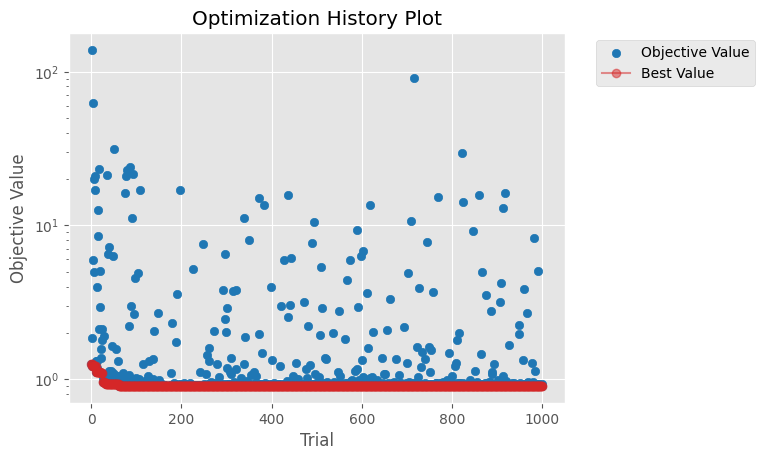

/var/folders/6m/8_2yd721373cx0m954405yd00000gn/T/ipykernel_80939/4023557214.py:7: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_param_importances(study)


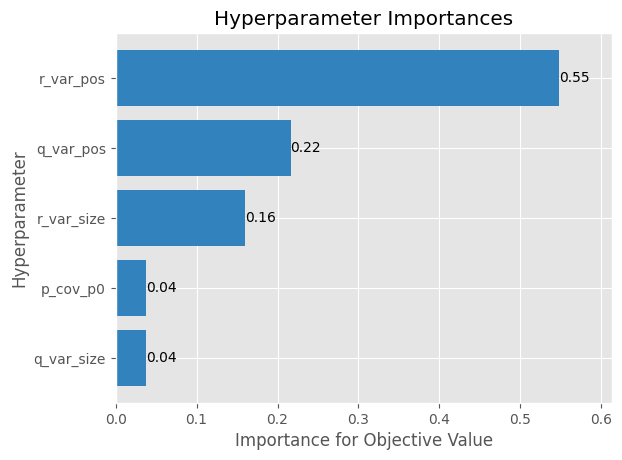

/var/folders/6m/8_2yd721373cx0m954405yd00000gn/T/ipykernel_80939/4023557214.py:10: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=['q_var_pos', 'r_var_pos'])


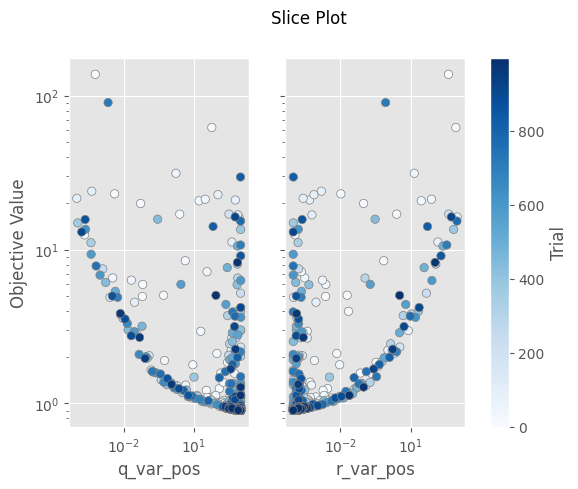

/var/folders/6m/8_2yd721373cx0m954405yd00000gn/T/ipykernel_80939/4023557214.py:13: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=['q_var_size', 'r_var_size', 'p_cov_p0'])


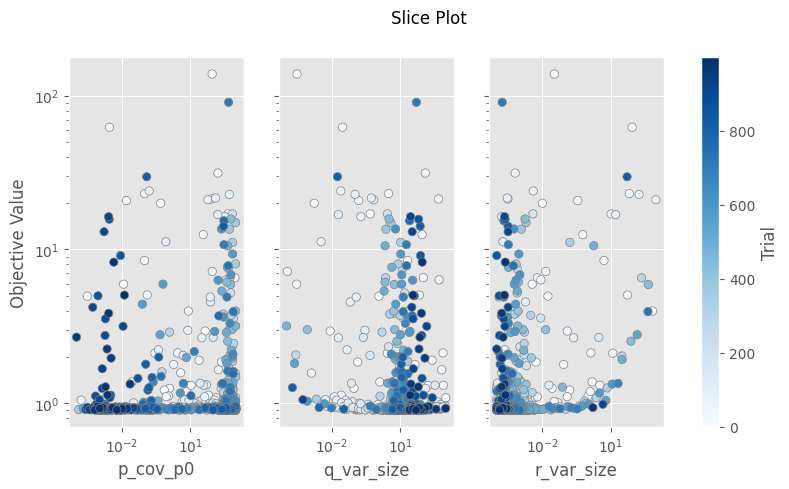

In [6]:
import matplotlib.pyplot as plt

fig = optuna.visualization.matplotlib.plot_optimization_history(study)
plt.yscale('log') # use log scale for y axis
plt.show()

fig = optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

optuna.visualization.matplotlib.plot_slice(study, params=['q_var_pos', 'r_var_pos'])
plt.yscale('log') 
plt.show()
optuna.visualization.matplotlib.plot_slice(study, params=['q_var_size', 'r_var_size', 'p_cov_p0'])
plt.yscale('log') 
plt.show()

import pandas as pd

df = pd.DataFrame(study.trials)
df.to_csv('optuna_trials.csv')